# StoryCloze Evaluation using L1 Attention with GPT2

This notebook evaluates the performance of EcoTransformers on the [story_cloze](https://huggingface.co/datasets/lecslab/story_cloze) dataset.

If possible, run this notebook on Google Colab, using an A100, High-RAM GPU.



In [1]:
!pip install -U datasets fsspec --quiet
!pip uninstall transformers -y
!pip install --no-cache-dir transformers

Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 206.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 364.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.5
    Uninstalling huggingface-hub-0.33.5:
      Successfully uninstalled huggingface-hub-0.33.5


In [41]:
# Imports for running the test (not related to library)

from torch.utils.data import (DataLoader,
                              Dataset)

from datasets import (load_dataset,
                      DatasetDict)
import transformers
from transformers import (GPT2Config,
                          GPT2Tokenizer,
                          default_data_collator)

import random

In [42]:
## Set up os variables for huggingface cache

import os

os.environ["HF_DATASETS_CACHE"] = "/content/hf_dataset_cache"
os.environ["HF_HOME"] = "/content/hf_home"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Importing l1_distance.py

The following block contains all the code from l1_distance.py, mimicking how you could use the library to modify the forward function of an existing architecture.

In [43]:
# Imports
import torch
import torch.nn as nn
from transformers.generation import GenerationMixin
from transformers.models.gpt2.modeling_gpt2 import (GPT2Attention,
                                                    GPT2MLP,
                                                    GPT2Block,
                                                    GPT2SequenceSummary,
                                                    GPT2PreTrainedModel,
                                                    GPT2Model,
                                                    GPT2LMHeadModel,
                                                    GPT2PreTrainedModel,
                                                    GPT2ForSequenceClassification
                                                    )
from transformers.pytorch_utils import Conv1D

from typing import Callable, Optional, Tuple, Union

from transformers.utils import logging

from dataclasses import dataclass
from typing import Callable, Optional, Tuple, Union

from transformers.cache_utils import Cache, EncoderDecoderCache
from transformers.generation import GenerationMixin
from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS, PreTrainedModel
from transformers.pytorch_utils import Conv1D
from transformers.utils import logging

In [62]:
# Library functions

MAX_LENGTH=128

logger = logging.get_logger(__name__)


def generate_tensor_c(A, B):
  """
  Generates tensor C based on the given formula.

  Args:
    A: A torch tensor of shape (i, j, k, d).
    B: A torch tensor of shape (i, j, l, d).

  Returns:
    A torch tensor C of shape (i, k, l).
  """
  # Get dimensions of A and B
  i_dim, j_dim, k_dim, d_dim = A.shape
  difference = torch.abs(A.unsqueeze(3) - B.unsqueeze(2)) # Unsqueeze adds a dimension

  # Sum over the last dimension (d)
  C = torch.sum(difference, dim=-1)

  return C

def generate_tensor_c_batch(A, B, batch_size=8):

  # Get dimensions of A and B
  i_dim, j_dim, k_dim, d_dim = A.shape
  l_dim = B.shape[2]

  result = torch.empty(i_dim, j_dim, k_dim, l_dim, device=A.device, dtype=A.dtype)

  for i in range(0, k_dim, batch_size):
    end = min(i + batch_size, k_dim)
    A_batch = A[:,:,i:end,:]  # shape (i,j, batch, d)
    difference = torch.abs(A_batch[:, :, :, None, :] - B[:, :, None, :, :]) # (i, j, batch, l, d)
    dist_batch = torch.sum(difference, dim=-1)
    result[:, :, i:end, :] = dist_batch

  return result


def L1_eager_attention_forward(module, query, key, value, attention_mask, head_mask=None, **kwargs):

    """
    Performs forward for eager attention using L1 normalization.
    """

    attn_weights = generate_tensor_c_batch(query, key) * (-1)
    #attn_weights = torch.matmul(query, key.transpose(-1, -2))

    if module.scale_attn_weights:
        attn_weights = attn_weights / torch.full(
            [], value.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
        )

    # Layer-wise attention scaling
    if module.scale_attn_by_inverse_layer_idx:
        attn_weights = attn_weights / float(module.layer_idx + 1)

    ###causal mask is always used in decoder only transformer
    ####GPT-2 doesn't use encoder-decoder attention (unlike T5 or BART).
    ####It uses self-attention, meaning each token attends within the same input sequence.
    ####Therefore, query, key, and value vectors are all computed from the same sequence — making their lengths equal.

    if not module.is_cross_attention:
        # if only "normal" attention layer implements causal mask
        query_length, key_length = query.size(-2), key.size(-2)
        causal_mask = module.bias[:, :, key_length - query_length : key_length, :key_length]
        mask_value = torch.finfo(attn_weights.dtype).min
        # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
        # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
        mask_value = torch.full([], mask_value, dtype=attn_weights.dtype, device=attn_weights.device)
        attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)

    if attention_mask is not None:
      # Apply the attention mask
      causal_mask = attention_mask[:, :, :, : key.shape[-2]]
      attn_weights = attn_weights + causal_mask

    attn_weights = nn.functional.softmax(attn_weights, dim=-1)

    # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
    attn_weights = attn_weights.type(value.dtype)
    attn_weights = module.attn_dropout(attn_weights)

    # Mask heads if we want to
    if head_mask is not None:
        attn_weights = attn_weights * head_mask

    attn_output = torch.matmul(attn_weights, value)
    attn_output = attn_output.transpose(1, 2)

    return attn_output, attn_weights


# Patch in model
class L1GPT2Attention(GPT2Attention):

    def __init__(self, config, layer_idx=None, is_cross_attention=False):

        # Inherit from GPT2Attention
        super().__init__(config)

        # Completely change the init function (for safety)
        self.config = config

        max_positions = config.max_position_embeddings
        self.register_buffer(
            "bias",
            torch.tril(torch.ones((max_positions, max_positions), dtype=torch.bool)).view(
                1, 1, max_positions, max_positions
            ),
            persistent=False,
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4), persistent=False)

        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.split_size = self.embed_dim
        if self.head_dim * self.num_heads != self.embed_dim: # Corrected self.nit to self.num_heads
            raise ValueError(
                f"`embed_dim` must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {self.num_heads})."
            )

        self.scale_attn_weights = config.scale_attn_weights
        self.is_cross_attention = is_cross_attention

        # Layer-wise attention scaling, reordering, and upcasting
        self.scale_attn_by_inverse_layer_idx = config.scale_attn_by_inverse_layer_idx
        self.layer_idx = layer_idx
        self.reorder_and_upcast_attn = config.reorder_and_upcast_attn


        self.c_attn = Conv1D(3 * self.embed_dim, self.embed_dim) # mapping for the key, value, and l matrix (utility matrix)
        self.q_attn = Conv1D(self.embed_dim, self.embed_dim) # mapping for the query matrix

        self.c_proj = Conv1D(self.embed_dim, self.embed_dim)

        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.is_causal = True

        self.pruned_heads = set()

    # Moved forward method outside of __init__
    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        past_key_value: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
        **kwargs,
    ) -> Tuple[Union[torch.Tensor, Tuple[torch.Tensor]], ...]:
        # FIX THIS LATER
        is_cross_attention = encoder_hidden_states is not None
        if is_cross_attention:
            if not hasattr(self, "q_attn"):
                raise ValueError(
                    "If class is used as cross attention, the weights `q_attn` have to be defined. "
                    "Please make sure to instantiate class with `GPT2Attention(..., is_cross_attention=True)`."
                )

            query_states = self.q_attn(hidden_states)
            key_states, value_states = self.c_attn(encoder_hidden_states).split(self.split_size, dim=2)
            attention_mask = encoder_attention_mask
        else:
            query_states, key_states, value_states = self.c_attn(hidden_states).split(self.split_size, dim=2)

        shape_q = (*query_states.shape[:-1], -1, self.head_dim)
        shape_kv = (*key_states.shape[:-1], -1, self.head_dim)

        query_states = query_states.view(shape_q).transpose(1, 2)
        key_states = key_states.view(shape_kv).transpose(1, 2)
        value_states = value_states.view(shape_kv).transpose(1, 2)

        if past_key_value is not None:
            if isinstance(past_key_value, EncoderDecoderCache):
                if is_cross_attention:
                    past_key_value = past_key_value.cross_attention_cache
                else:
                    past_key_value = past_key_value.self_attention_cache
            cache_kwargs = {"cache_position": cache_position}
            key_states, value_states = past_key_value.update(
                key_states, value_states, self.layer_idx, cache_kwargs=cache_kwargs
            )

        is_causal = attention_mask is None and query_states.shape[-2] > 1 and not is_cross_attention

        using_eager = self.config._attn_implementation == "eager"

        # Define the new attention_interface as the custom L1_eager_attention_forward
        attention_interface: Callable = L1_eager_attention_forward

        # XM: changing this to always be eager
        # if self.config._attn_implementation != "eager":
        #     if self.config._attn_implementation == "sdpa" and (output_attentions or head_mask is not None):

        using_eager = True
        logger.warning_once(
            "`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to "
            'eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.'
        )
            # else:
            #     print("else")
            #     # Attention functions are consistent with previous equivalent attention classes, however they do not support some options
            #     # (e.g. layer scaling, head mask) that eager supports. These implementations are thus equivalent to previous code, but
            #     # not necessarily to eager (if mentioned options are provided).
            #     attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]

        if using_eager and self.reorder_and_upcast_attn:
            # using eager
            print("using eager_attention_forward")
            attn_output, attn_weights = self._upcast_and_reordered_attn(
                query_states, key_states, value_states, attention_mask, head_mask
            )
        else:
            dropout = kwargs.pop('dropout', self.attn_dropout.p if self.training else 0.0)
            attn_output, attn_weights = attention_interface(
                self,
                query=query_states,
                key=key_states,
                value=value_states,
                attention_mask=attention_mask,
                head_mask=head_mask,
                dropout=dropout,
                is_causal=is_causal,
                **kwargs,
            )

        attn_output = attn_output.reshape(*attn_output.shape[:-2], -1).contiguous()
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)

        return attn_output, attn_weights


# Create L1 "clones" inheriting from GPT2 equivalents to patch in our changes to the forward function.

class L1GPT2Block(GPT2Block):

    def __init__(self, config, layer_idx=None):
        super().__init__(config, layer_idx=layer_idx)
        self.attn = L1GPT2Attention(config,
                                        layer_idx=layer_idx)

class L1GPT2Model(GPT2Model):

    def __init__(self, config):
        super().__init__(config)
        self.h = nn.ModuleList([L1GPT2Block(config, layer_idx=i)
        for i in range(config.num_hidden_layers)])


class L1GPT2LMHeadModel(GPT2PreTrainedModel, GenerationMixin):

    def __init__(self, config):
        super().__init__(config)
        self.transformer = L1GPT2Model(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)


class L1GPT2ForSequenceClassification(GPT2ForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.transformer = L1GPT2Model(config)

In [63]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Obtain Dataset

The ____ dataset looks like (for example)

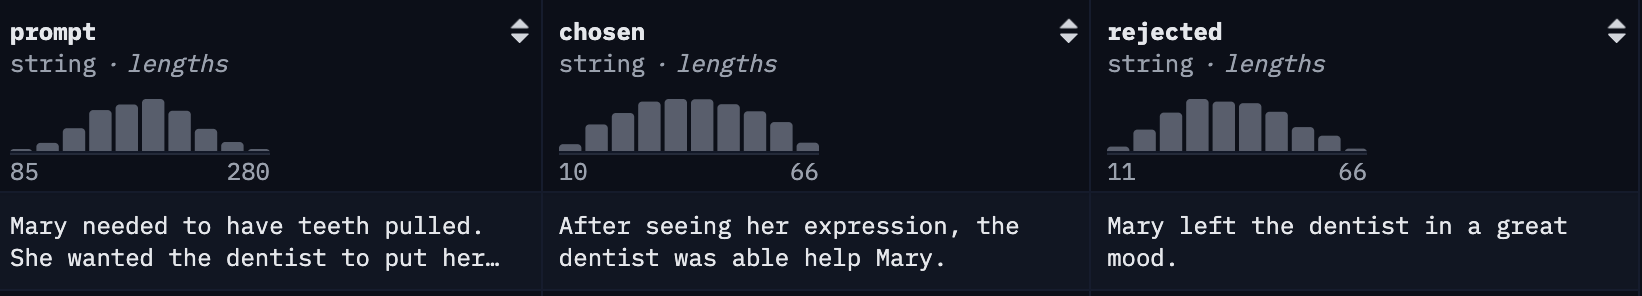
```

and we will consequently have to preprocess the text.

We want to pre-process the text as:

```
{
  'prompt': 'James was very low on money and needed food. So he decided to count his pennies and see what he came up with. He came up with three dollars and eight cents. But then he remembered he had a visa gift card from his birthday!',
  'chosen': 'James was then able to buy himself food.',
  'rejected': 'James did not have any money.'
}
```


In [65]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

## Custom Dataset

We create a custom Dataset class to help organize the dataset for training.

In [66]:
class StoryClozeDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=MAX_LENGTH):
        """
        Args:
            dataset: A HuggingFace Dataset object
            tokenizer: HuggingFace tokenizer
            max_length: maximum sequence length to truncate the input
        """
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the prompt, chosen candidate, and rejected candidate
        prompt = self.dataset[idx]['prompt']
        chosen = self.dataset[idx]['chosen']
        rejected = self.dataset[idx]['rejected']

        # The correct candidate is 'chosen', and the incorrect candidate is 'rejected'
        label_chosen = 0  # 'chosen' is the correct continuation
        label_rejected = 1  # 'rejected' is the incorrect continuation

        # Tokenize prompt and candidates (chosen and rejected)
        input_chosen = prompt + " " + chosen
        input_rejected = prompt + " " + rejected

        # Tokenize both inputs
        encoding_chosen = self.tokenizer(input_chosen,
                                         truncation=True,
                                         padding="max_length",
                                         max_length=self.max_length,
                                         return_tensors="pt")
        encoding_rejected = self.tokenizer(input_rejected,
                                           truncation=True,
                                           padding="max_length",
                                           max_length=self.max_length,
                                           return_tensors="pt")

        if random.random() > 0.5:
          # Combine both candidates into the same batch
          # Do not flatten here; let the data collator handle batching and padding
          input_ids = torch.cat([encoding_chosen["input_ids"], encoding_rejected["input_ids"]], dim=0)
          attention_mask = torch.cat([encoding_chosen["attention_mask"], encoding_rejected["attention_mask"]], dim=0)

          # Combine labels (0 for chosen and 1 for rejected)
          # Keep labels as a tensor of shape [2] for the two candidates
          labels = torch.tensor([label_chosen, label_rejected], dtype=torch.long)
        else:
          # Combine both candidates into the same batch
          # Do not flatten here; let the data collator handle batching and padding
          input_ids = torch.cat([encoding_rejected["input_ids"], encoding_chosen["input_ids"]], dim=0)
          attention_mask = torch.cat([encoding_rejected["attention_mask"], encoding_chosen["attention_mask"]], dim=0)

          # Combine labels (0 for chosen and 1 for rejected)
          # Keep labels as a tensor of shape [2] for the two candidates
          labels = torch.tensor([label_rejected, label_chosen], dtype=torch.long)


        return {
            'input_ids': input_ids, # Return unflattened tensor
            'attention_mask': attention_mask, # Return unflattened tensor
            'labels': labels
        }

In [67]:
!rm -rf /root/.cache/huggingface
!rm -rf /content/hf_dataset_cache

In [68]:
data = load_dataset("lecslab/story_cloze", cache_dir="/content/hf_dataset_cache", download_mode="force_redownload")

train-00000-of-00001.parquet:   0%|          | 0.00/501k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/87.7k [00:00<?, ?B/s]

eval-00000-of-00001.parquet:   0%|          | 0.00/85.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2806 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/468 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/468 [00:00<?, ? examples/s]

In [69]:
dataset = StoryClozeDataset(data, tokenizer)

In [70]:
dataset.dataset["train"]

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 2806
})

```
DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 2806
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 468
    })
    eval: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 468
    })
})
```

In [71]:
train_data = StoryClozeDataset(dataset.dataset["train"], tokenizer)
test_data = StoryClozeDataset(dataset.dataset["test"], tokenizer)
val_data = StoryClozeDataset(dataset.dataset["eval"], tokenizer)

In [72]:
## Preprocess the data and create data_loaders

# Use default_data_collator for padding and batching
data_collator = default_data_collator

# Create the DataLoader with the correct collator
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_data, batch_size=4, collate_fn=data_collator)
test_loader = DataLoader(test_data, batch_size=4, collate_fn=data_collator)

In [73]:
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=MAX_LENGTH, # down from 1024
    n_embd=MAX_LENGTH, # down from 768
    n_layer=12,
    n_head=4,
    use_sdpa=False,
)

## Use Model

In [74]:
model = L1GPT2ForSequenceClassification(config) # 22M parameters
print(model.num_parameters())

9027200


In [75]:
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id
model = model.to(device)

In [76]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4) # change from 5e-4 to 5e-3

## Training loop

In [77]:
epochs = 5

In [78]:
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn


def train(model, train_dataloader, optimizer, device, num_epochs=1):
    """
    Train the model on the given training data by flattening the batch dimensions.

    Args:
        model: The model to be trained.
        train_dataloader: DataLoader for the training data.
        optimizer: Optimizer (e.g., AdamW).
        device: The device to train on (CPU or GPU).
        num_epochs: The number of training epochs.
    """

    loss_fn = nn.CrossEntropyLoss()
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        total_loss = 0
        # Wrap train_dataloader with tqdm for progress visualization
        for batch in train_dataloader:
            # Move batch to the correct device (GPU or CPU)
            input_ids = batch['input_ids'].to(device) # Shape: [batch_size, 2, seq_len]
            attention_mask = batch['attention_mask'].to(device) # Shape: [batch_size, 2, seq_len]
            labels = batch['labels'].to(device) # Shape: [batch_size, 2]

            # Flatten the second dimension (dim=1) to combine chosen and rejected into the batch dimension
            batch_size, num_choices, seq_len = input_ids.shape
            input_ids = input_ids.view(batch_size * num_choices, seq_len) # Shape: [batch_size * 2, seq_len]
            attention_mask = attention_mask.view(batch_size * num_choices, seq_len) # Shape: [batch_size * 2, seq_len]

            # Flatten the labels accordingly. The labels are [0, 1] for each original story,
            # corresponding to the chosen and rejected continuations. Flattening maintains this order.
            labels = labels.view(batch_size * num_choices) # Shape: [batch_size * 2]

            # FIX
            max_len = MAX_LENGTH
            input_ids = input_ids[:, :max_len]
            attention_mask = attention_mask[:, :max_len]
            #labels = labels[:, :max_len] # This line was commented out but could cause issues if active
            #position_ids = position_ids[:, :max_len]
            # FIX

            # Pass labels to the model to compute loss internally
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Retrieve the loss calculated within the model's forward pass
            logits = outputs.logits  # shape: [batch_size * 2, 2]
            loss = loss_fn(logits, labels)  # labels shape: [batch_size * 2]

            optimizer.zero_grad()

            loss.backward()

            # Clip gradients to prevent explosion
            clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()

        # Print the average loss for the epoch
        avg_epoch_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

In [79]:
train(model, train_dataloader=train_loader, optimizer=optimizer, device=device, num_epochs=epochs)

Epoch 1/5, Loss: 0.6947
Epoch 2/5, Loss: 0.6769
Epoch 3/5, Loss: 0.6098
Epoch 4/5, Loss: 0.5289
Epoch 5/5, Loss: 0.4594


In [80]:
def evaluate(model, eval_dataloader, device):
    """
    Evaluate the model on the given evaluation data.

    Args:
        model: The trained model.
        eval_dataloader: DataLoader for the evaluation data.
        device: The device to evaluate on (CPU or GPU).
    """
    loss_fn = nn.CrossEntropyLoss()
    model.eval()  # Set model to evaluation mode

    total_loss = 0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in eval_dataloader:
            input_ids = batch['input_ids'].to(device)     # [batch_size, 2, seq_len]
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)           # [batch_size, 2]

            batch_size, num_choices, seq_len = input_ids.shape
            input_ids = input_ids.view(batch_size * num_choices, seq_len)
            attention_mask = attention_mask.view(batch_size * num_choices, seq_len)
            labels = labels.view(batch_size * num_choices)

            input_ids = input_ids[:, :MAX_LENGTH]
            attention_mask = attention_mask[:, :MAX_LENGTH]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # [batch_size * 2, 2]

            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Get predicted class (index of max logit)
            preds = torch.argmax(logits, dim=1)  # [batch_size * 2]

            # Count correct predictions
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_examples += labels.size(0)

    avg_loss = total_loss / len(eval_dataloader)
    accuracy = total_correct / total_examples

    print(f"Evaluation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [81]:
evaluate(model, test_loader, device)

Evaluation Loss: 0.7375, Accuracy: 0.6015


(0.7374898032245473, 0.6014957264957265)